In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd


class MicrogridEnv(gym.Env):

    def __init__(self, data):
        super(MicrogridEnv, self).__init__()

        self.data_matrix = data[[
            'Avg_Temperature_C', 
            'Energy_Consumption_kWh', 
            'Household_Size', 
            'Peak_Hours_Usage_kWh'
        ]].to_numpy(dtype=np.float32)   

        self.max_vals = self.data_matrix.max(axis=0) + 1e-5
        self.total_data_len = len(self.data_matrix)
        self.episode_duration = 168  # 24 * 7
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)

    def reset(self, seed=42, options=None):
        super().reset(seed=seed)
        self.steps_taken = 0    
        self.current_step_idx = np.random.randint(0, self.total_data_len - self.episode_duration)
        self._load_data()
        
        return self._get_obs(), {}


    def step(self, action):
        shed_factor = float(action.item())

        actual_cost = self.consumption * (1 - shed_factor) * self.grid_price
        money_saved = (self.consumption * self.grid_price) - actual_cost
        temp_factor = (self.temp / 10.0)
        discomfort = (self.consumption * (shed_factor **2))* (temp_factor)

        raw_reward = money_saved - discomfort

        if self.steps_taken == 0 and np.random.rand() < 0.1: 
             print(f"  [Quadratic Logic] Shed: {shed_factor:.2f} | Saved: ${money_saved:.2f} | Pain: {discomfort:.2f} | Net: {raw_reward:.2f}")

        self.steps_taken += 1
        self.current_step_idx += 1

        terminated = (self.steps_taken >= self.episode_duration)

        if not terminated:
            self._load_data()
            new_observation = np.array([self.temp, self.consumption, self.household_size, self.grid_price], dtype=np.float32)
        else:
            new_observation = np.zeros(4, dtype=np.float32)

        return new_observation, raw_reward, terminated, False, {}
    
    def _load_data(self):
        row = self.data_matrix[self.current_step_idx]
        self.temp = row[0]
        self.consumption = row[1]
        self.household_size = row[2]
        self.peak_usage = row[3]
        self.grid_price = 0.12 + (0.10 * self.peak_usage)
        
    def _get_obs(self):
        obs = np.array([self.temp, self.consumption, self.household_size, self.grid_price], dtype=np.float32)
        obs[:3] = obs[:3] / self.max_vals[:3] 
        return obs

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ActorCriticNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCriticNetwork, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 64)

        self.actor_mu = nn.Linear(64, self.action_dim) 
        self.actor_sig = nn.Linear(64, self.action_dim) 

        self.critic = nn.Linear(64, 1) 

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        actor_mu = torch.sigmoid(self.actor_mu(x))
        actor_sig = (torch.sigmoid(self.actor_sig(x)) * 0.3) + 0.01

        critic = self.critic(x)

        return actor_mu, actor_sig, critic



Debug Ep 0: Mu=0.09836026281118393, Sigma=0.0434090718626976, Reward=0.20423930883407593
  [Quadratic Logic] Shed: 0.46 | Saved: $5.31 | Pain: 6.89 | Net: -1.58
Debug Ep 10: Mu=0.10359024256467819, Sigma=0.024768095463514328, Reward=0.3740893602371216
  [Quadratic Logic] Shed: 0.36 | Saved: $2.83 | Pain: 2.21 | Net: 0.62
  [Quadratic Logic] Shed: 0.65 | Saved: $3.56 | Pain: 7.32 | Net: -3.76
Debug Ep 20: Mu=0.08667150139808655, Sigma=0.01372154988348484, Reward=0.8686476945877075
  [Quadratic Logic] Shed: 0.30 | Saved: $2.17 | Pain: 1.95 | Net: 0.22
  [Quadratic Logic] Shed: 0.58 | Saved: $2.36 | Pain: 3.93 | Net: -1.57
Debug Ep 30: Mu=0.15496259927749634, Sigma=0.01884251832962036, Reward=0.7242292165756226
Debug Ep 40: Mu=0.49202367663383484, Sigma=0.016824668273329735, Reward=0.24617481231689453
  [Quadratic Logic] Shed: 0.48 | Saved: $4.29 | Pain: 6.76 | Net: -2.48
Debug Ep 50: Mu=0.04411449283361435, Sigma=0.013772190548479557, Reward=0.16108405590057373
  [Quadratic Logic] Shed: 

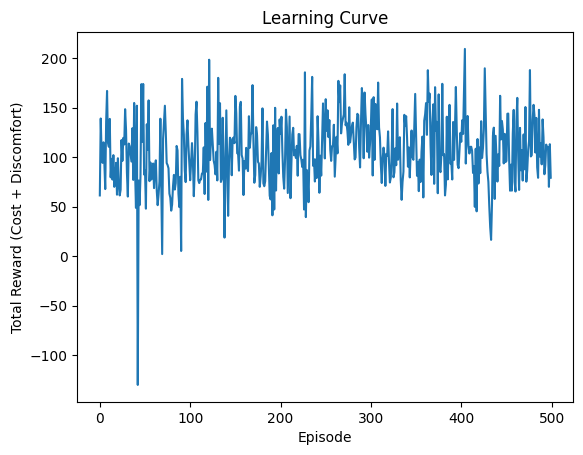

In [3]:
df = pd.read_csv("household_energy_consumption.csv")

env = MicrogridEnv(df)

input_dim = 4
action_dim = 1

model = ActorCriticNetwork(input_dim=input_dim, action_dim=action_dim)
gamma = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

all_rewards = []
num_episodes = 500

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).float().unsqueeze(0)
    episode_reward = 0
    terminated = False

    while not terminated:
        mu, sigma, value = model(state)

        normal_dist = torch.distributions.Normal(mu, sigma)
        action = torch.clamp(normal_dist.sample(), 0.0, 1.0)

        next_state_np, reward, terminated, _, _ = env.step(action)
        next_state = torch.from_numpy(next_state_np).float().unsqueeze(0)

        episode_reward += reward

        _, _, next_value = model(next_state)

        if terminated:
            target = reward
        else:
            target = reward + gamma * next_value

        advantage = target - value

        critic_loss = advantage.pow(2)
        actor_loss = -(normal_dist.log_prob(action) * advantage.detach())
        total_loss = actor_loss + critic_loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state

    all_rewards.append(episode_reward)

    if episode % 10 == 0:
            print(f"Debug Ep {episode}: Mu={mu.item()}, Sigma={sigma.item()}, Reward={reward}")

import matplotlib.pyplot as plt
plt.plot(all_rewards)
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Cost + Discomfort)")
plt.show()
        


Running Validation Simulation...


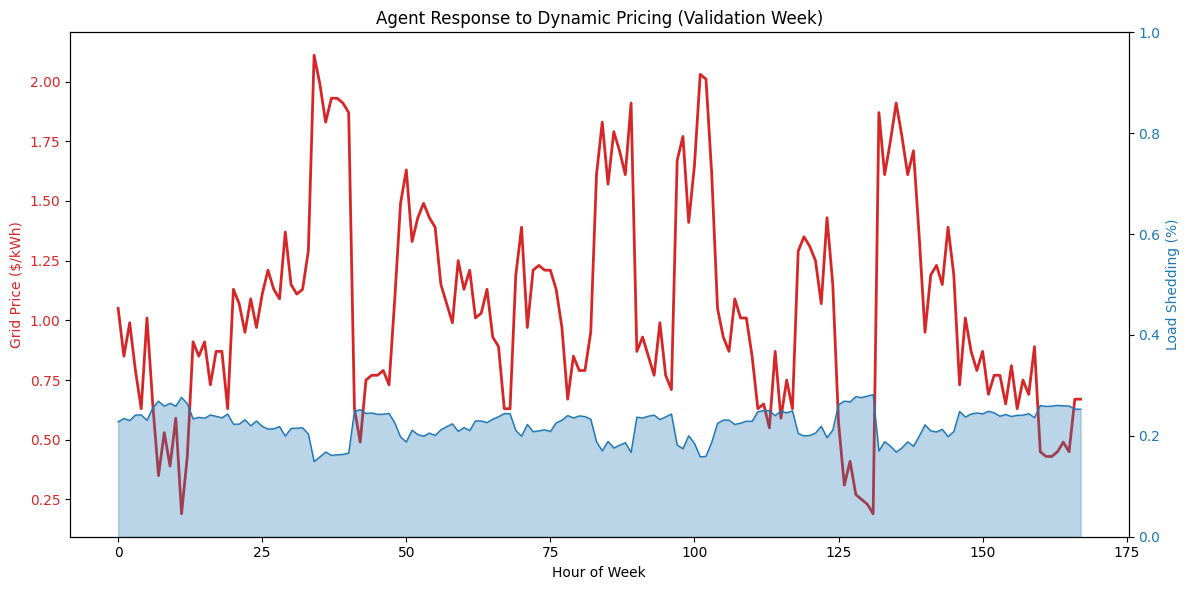

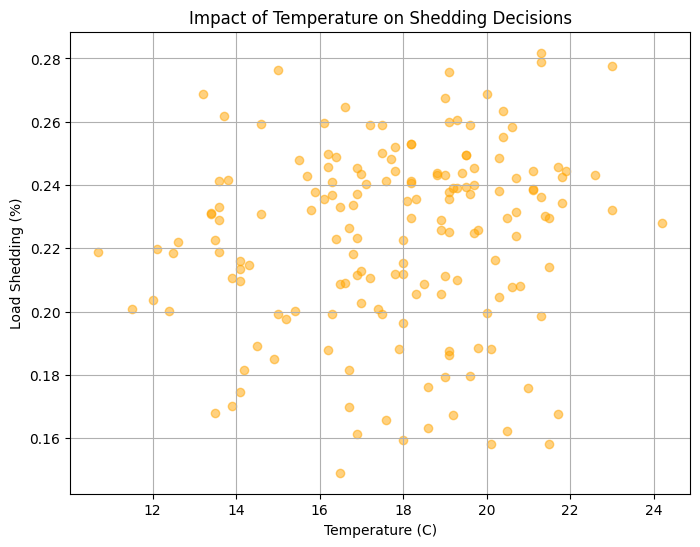

In [5]:

model.eval()

test_start_idx = env.total_data_len - 168 
test_data = env.data_matrix[test_start_idx:]

prices = []
actions = []
temps = []
savings_log = []

state_row = test_data[0]

price = 0.15 + (0.20 * state_row[3])
obs = np.array([state_row[0], state_row[1], state_row[2], price], dtype=np.float32)
obs[:3] = obs[:3] / env.max_vals[:3]

current_state = torch.from_numpy(obs).float().unsqueeze(0)

print("Running Validation Simulation...")

for i in range(168):
    with torch.no_grad():
        mu, sigma, _ = model(current_state)
        action = mu.item()
    
    real_price = price 
    real_temp = state_row[0]
    
    prices.append(real_price)
    actions.append(action)
    temps.append(real_temp)
    
    if i < 167:
        state_row = test_data[i+1]
        price = 0.15 + (0.20 * state_row[3])
        obs = np.array([state_row[0], state_row[1], state_row[2], price], dtype=np.float32)
        obs[:3] = obs[:3] / env.max_vals[:3]
        current_state = torch.from_numpy(obs).float().unsqueeze(0)


import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Hour of Week')
ax1.set_ylabel('Grid Price ($/kWh)', color=color)
ax1.plot(prices, color=color, linewidth=2, label='Grid Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Load Shedding (%)', color=color)
ax2.fill_between(range(len(actions)), actions, color=color, alpha=0.3, label='Agent Action (Shedding)')
ax2.plot(actions, color=color, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.0)

plt.title("Agent Response to Dynamic Pricing (Validation Week)")
fig.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(temps, actions, alpha=0.5, c='orange')
plt.xlabel("Temperature (C)")
plt.ylabel("Load Shedding (%)")
plt.title("Impact of Temperature on Shedding Decisions")
plt.grid(True)
plt.show()